# Experiment: PU learning techniques applied to reseller weborder propensity

In [1]:
import pandas as pd                 # for data handling
import numpy as np                  # for random selections, mainly
import matplotlib.pyplot as plt     # for plotting
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 10,7  # graph dimensions
plt.rcParams['font.size'] = 14         # graph font size

In [3]:
# Data loading and cleaning goes here; details are redacted, but the result 
# is a pandas dataframe "X" of features and a pandas series "y" of targets 
# (1 for positive, 0 for unlabeled).

In [4]:
# Check the contents of the set
print('%d resellers and %d features' % (X.shape))
print('%d weborder-intensive out of %d resellers' % (sum(y), len(y)))

24071 resellers and 79 features
5978 weborder-intensive out of 24071 resellers


In [5]:
# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2000
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [6]:
# Check the new contents of the set
print('%d weborder-intensive out of %d resellers' % (sum(y), len(y)))

3978 weborder-intensive out of 24071 resellers


## Standard classifier

In [7]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1,          # Use all CPU cores
    oob_score = True      # Keep track of OOB scores (we'll use them below)
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

## Bagging
### The fast and easy way

In [8]:
# Store the average OOB scores found during training of the RF model
results['output_oob'] = rf.oob_decision_function_[:,1]

### The proper PU way

In [9]:
# Again, use 1000 trees
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# Keep track of the indices of positive and unlabeled data points
iP = y[y > 0].index
iU = y[y <= 0].index

# For each data point, keep track of how many times it has been OOB...
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# ...and the sum of its OOB scores
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # Find the OOB data points for this round
    i_oob = list(set(iU) - set(ib))

    # Get the training data (ALL positives and the bootstrap 
    # sample of unlabeled points) and build the tree
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # Record the OOB scores from this round
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# Finally, store the scores assigned by this approach
results['output_bag'] = sum_oob / num_oob

## Two-step

In [10]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the OOB scores from before
pred = rf.oob_decision_function_[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Classifier to be used for step 2
rf2 = RandomForestClassifier(
    n_estimators = 1000, n_jobs = -1, oob_score = True
)

# Limit to 20 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(20):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get OOB scores
    rf2.fit(X, ys)
    pred = rf2.oob_decision_function_[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = rf2.oob_decision_function_[:,-1]

Step 1 labeled 0 new positives and 496 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 219 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 180 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 132 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 91 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 76 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 64 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 67 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 38 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 47 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 38 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 27 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 30 new negatives.
Doing step 2... Step 1 labeled 1 new positives and 30 new negatives.
Doing step 2... Step 1 labeled 1 new positives

## Comparison of approaches

In [11]:
# For each data point, calculate the average score from the four approaches
results['output_all'] = results[[
    'output_std', 'output_oob', 'output_bag', 'output_stp'
]].mean(axis = 1)

In [12]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_oob, y_bag, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_oob.append(
        results[results.label == 0].sort_values(
            'output_oob', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
    y_stp.append(
        results[results.label == 0].sort_values(
            'output_stp', ascending = False
        ).head(t).truth.mean()
    )
    y_all.append(
        results[results.label == 0].sort_values(
            'output_all', ascending = False
        ).head(t).truth.mean()
    )
    

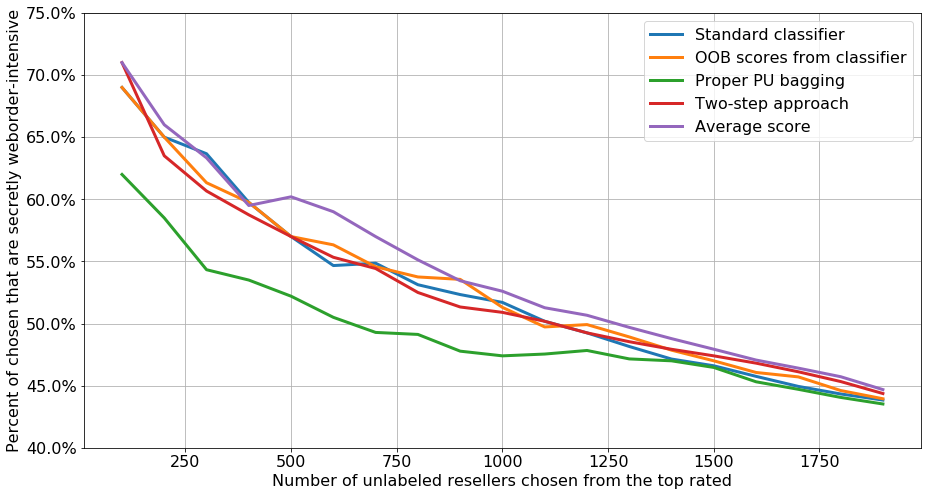

In [13]:
# Graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_oob,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.1f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled resellers chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly weborder-intensive')
plt.legend([
    'Standard classifier', 
    'OOB scores from classifier', 
    'Proper PU bagging', 
    'Two-step approach', 
    'Average score'
])
plt.grid()
plt.show()

## Application

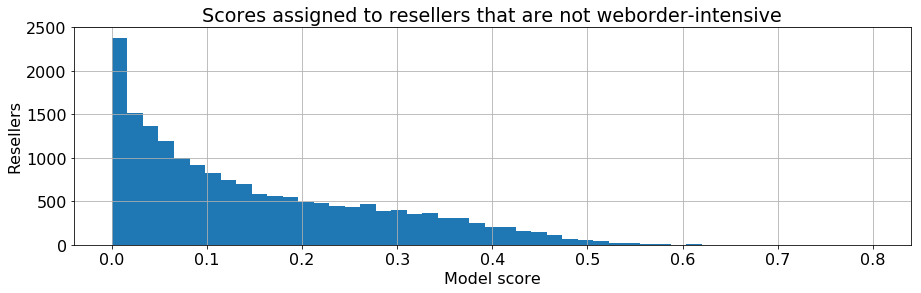

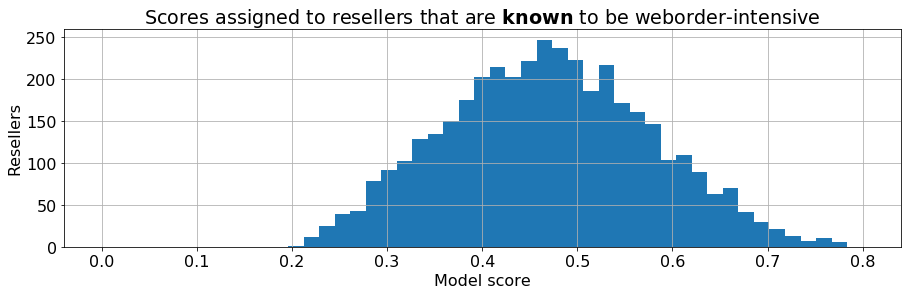

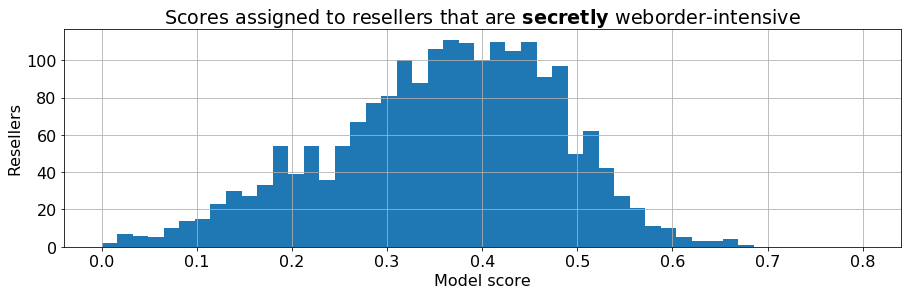

In [17]:
# Show distribution of scores for the truly unlabeled
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 4
results[results.truth == 0].output_all.hist(
    bins = np.linspace(0, .8, 50)
)
plt.xlabel('Model score')
plt.ylabel('Resellers')
s = 'Scores assigned to resellers '
plt.title(s + 'that are not weborder-intensive')
plt.show()

# Show distribution of scores for the known positives
results[results.label == 1].output_all.hist(
    bins = np.linspace(0, .8, 50)
)
plt.xlabel('Model score')
plt.ylabel('Resellers')
plt.title(s + r'that are ${\bf known}$ to be weborder-intensive')
plt.show()

# Show distribution of scores for the hidden positives
results[results.truth > results.label].output_all.hist(
    bins = np.linspace(0, .8, 50)
)
plt.xlabel('Model score')
plt.ylabel('Resellers')
plt.title(s + r'that are ${\bf secretly}$ weborder-intensive')
plt.show()

In [15]:
# Following are the end results of running this notebook with hidden_size = 5400

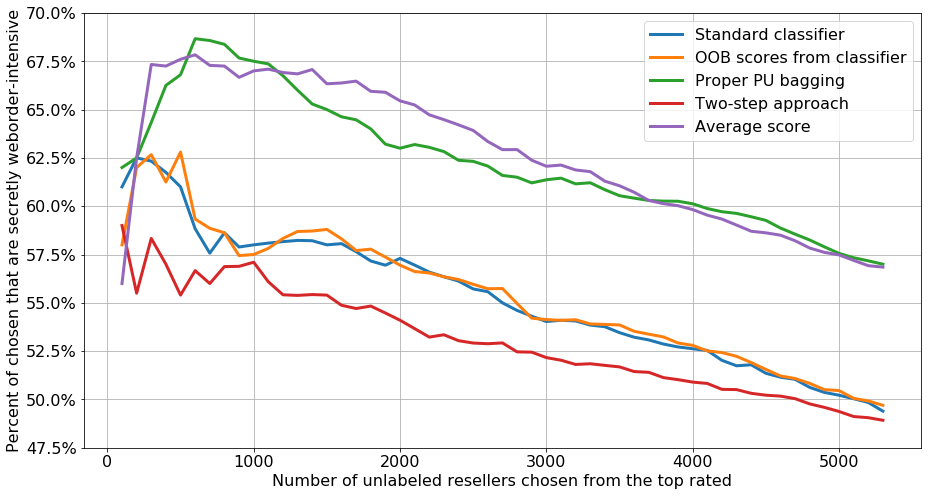

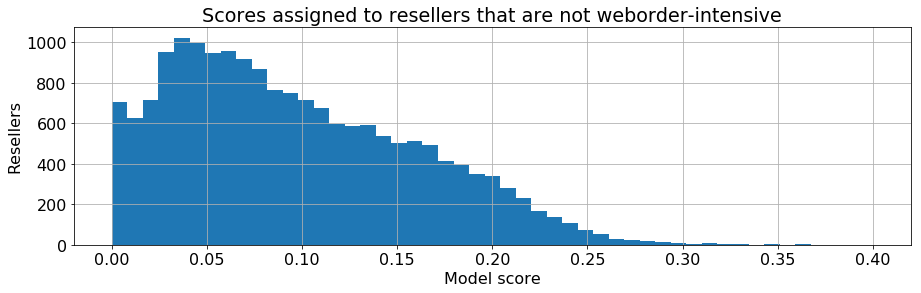

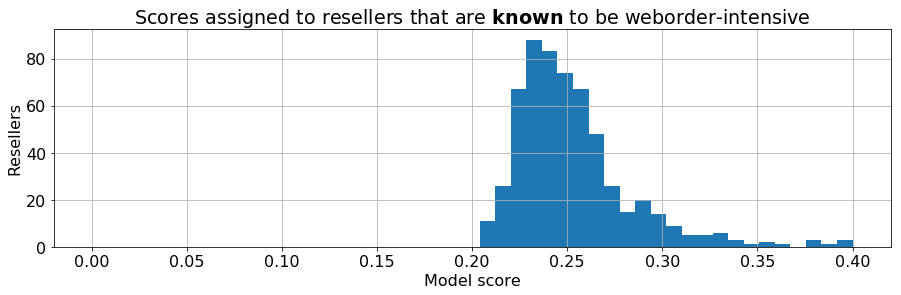

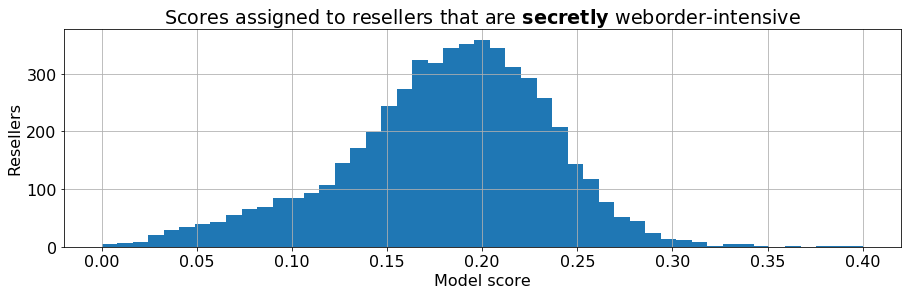